# Train a VAE on L1000 Data

In [1]:
import sys
import pathlib
import numpy as np
import pandas as pd
sys.path.insert(0, "../../scripts")
from utils import load_data, infer_L1000_features
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from sklearn.decomposition import PCA

from tensorflow import keras


from vae import VAE
from tensorflow.keras.models import Model, Sequential
import seaborn
import tensorflow as tf


In [2]:
# np.random.seed(123)
# python_random.seed(123)
# tf.random.set_random_seed(1234)

In [3]:
data_splits = ["train", "valid", "test", "complete"]
# data_splits = ["train", "valid","test"]
data_dict = load_data(data_splits, dataset="L1000")
# data_dict["train"] = data_dict["train"][data_dict["train"].cell_id == "A549"].reset_index(drop = True)
# data_dict["valid"] = data_dict["valid"][data_dict["valid"].cell_id == "A549"].reset_index(drop = True)
# data_dict["test"] = data_dict["test"][data_dict["test"].cell_id == "A549"].reset_index(drop = True)
# data_dict["complete"] = data_dict["complete"][data_dict["complete"].cell_id == "A549"].reset_index(drop = True)

In [4]:
# Prepare data for training

meta_features = infer_L1000_features(data_dict["train"], metadata=True)
profile_features = infer_L1000_features(data_dict["train"])

train_features_df = data_dict["train"].reindex(profile_features, axis="columns")
train_meta_df = data_dict["train"].reindex(meta_features, axis="columns")

valid_features_df = data_dict["valid"].reindex(profile_features, axis="columns")
valid_meta_df = data_dict["valid"].reindex(meta_features, axis="columns")

test_features_df = data_dict["test"].reindex(profile_features, axis="columns")
test_meta_df = data_dict["test"].reindex(meta_features, axis="columns")

complete_features_df = data_dict["complete"].reindex(profile_features, axis="columns")
complete_meta_df = data_dict["complete"].reindex(meta_features, axis="columns")

In [5]:
#shuffle columns
def shuffle_each_column(df):
    columns = df.columns
    df_copy = df.copy()
    for column in columns:
        df_copy[column] = df_copy[column].sample(frac=1).reset_index(drop=True)
    return (df_copy)

In [6]:
# train_features_df = shuffle_each_column(train_features_df)
# valid_features_df = shuffle_each_column(valid_features_df)
# test_features_df = shuffle_each_column(test_features_df)

In [7]:
print(train_features_df.shape)
train_features_df.head(3)

(94440, 978)


,780,7849,6193,23,9552,387,10921,10285,533,6194,...,54681,11000,6915,6253,7264,5467,2767,23038,57048,79716
0,0.74578,-0.007757,-0.063908,-0.115210,0.83776,-0.80023,-0.25787,-0.621180,-0.53313,-0.260430,...,-0.458550,0.51684,2.86550,-0.152210,-0.907810,1.47600,-0.42918,-0.81612,0.28533,0.37183
1,-0.29710,-0.180930,0.482090,-0.337130,-0.47045,-0.44483,0.38475,-0.566390,0.27726,0.000645,...,0.008161,-0.33238,-0.20174,-0.605390,0.024792,0.60759,0.41555,0.50640,0.23908,-0.23696
2,-0.75812,-0.283820,0.594330,0.089136,-0.85230,-0.78754,0.20291,0.018564,-0.22745,-0.839810,...,0.289560,0.16598,0.54440,-0.053607,0.439350,0.42920,-0.37040,-0.51931,-0.21799,-1.29360


In [8]:
print(valid_features_df.shape)
valid_features_df.head(3)

(11805, 978)


,780,7849,6193,23,9552,387,10921,10285,533,6194,...,54681,11000,6915,6253,7264,5467,2767,23038,57048,79716
0,-0.534400,0.552700,0.000000,-0.95760,-0.3264,-0.25560,0.00000,0.00000,1.88250,1.86290,...,5.22050,-0.96970,-1.133800,-1.079700,-2.29810,0.8493,0.29560,0.84640,0.19020,-0.47540
1,-0.029159,0.039928,0.045024,0.26740,-1.0234,0.58926,0.57561,0.60793,0.33281,-0.65153,...,-0.25789,0.46169,0.022211,-0.035998,0.67575,2.2909,0.24359,-0.14676,-0.84884,-0.16919
2,0.365290,-1.311300,-0.153500,0.72378,-1.1094,-0.38681,1.05910,0.12169,-1.01300,0.83094,...,-0.22982,-0.21314,-0.088198,0.527700,0.49855,-1.3877,1.00980,-0.21835,0.16329,-0.79029


In [9]:
print(test_features_df.shape)
test_features_df.head(3)

(11805, 978)


,780,7849,6193,23,9552,387,10921,10285,533,6194,...,54681,11000,6915,6253,7264,5467,2767,23038,57048,79716
0,0.28158,1.6038,-1.58650,-0.41677,-2.34260,3.12320,-0.10233,1.62600,0.115840,-0.000233,...,-0.49069,-1.14930,-0.16539,0.49864,1.077800,1.66230,-1.66900,-0.49738,0.51629,1.08940
1,0.77369,1.0853,0.75758,1.04900,1.18270,0.69324,-0.43503,-0.88949,-0.075833,0.208990,...,0.10747,0.97814,0.85407,0.10528,-0.370430,0.89069,-0.26969,-0.98646,-1.07350,0.48240
2,0.63079,1.9072,-1.65190,0.26266,0.68423,-0.38400,1.63160,0.78741,0.732920,-2.431700,...,-1.83770,-0.56064,0.93692,0.96585,-0.036786,1.35430,2.15870,-0.28158,0.53111,-0.46053


In [10]:
print(complete_features_df.shape)
complete_features_df.head(3)

(118050, 978)


,780,7849,6193,23,9552,387,10921,10285,533,6194,...,54681,11000,6915,6253,7264,5467,2767,23038,57048,79716
0,4.26410,0.057249,-2.13930,-0.22178,-0.37656,1.91380,0.065576,-0.86895,-0.10227,0.00000,...,5.246200,0.057058,-1.25620,-0.025255,0.168860,-1.639100,0.68510,-0.41942,1.71610,-0.47234
1,-0.38221,0.304310,-0.99592,-0.67083,-0.64824,0.62161,0.889530,0.20376,0.19481,-0.45637,...,0.206690,-0.010866,-0.87206,-0.223750,0.074144,0.093595,0.32667,1.04810,-0.50518,-0.61832
2,-0.57171,-0.755000,-0.71011,0.42889,0.27261,0.31436,-1.545800,0.64195,-0.87685,0.00000,...,-0.005612,1.194500,0.17111,0.334370,-1.089300,-0.114640,0.30483,-0.24947,-0.42835,1.58500


In [11]:
encoder_architecture = [500, 250]
decoder_architecture = [250, 500]


In [12]:
L1000_vae = VAE(
    input_dim=train_features_df.shape[1],
    latent_dim=50,
    batch_size=512,
    encoder_batch_norm=True,
    epochs= 100,
    learning_rate=0.001,
    encoder_architecture=encoder_architecture,
    decoder_architecture=decoder_architecture,
    beta=50,
    verbose=True,
)



L1000_vae.compile_vae()
#1575

In [13]:
L1000_vae.train(x_train=train_features_df, x_test=valid_features_df)

Epoch 1/100
185/185 [==============================] - 8s 33ms/step - loss: 2299.1898 - val_loss: 1761.0659
Epoch 2/100
185/185 [==============================] - 5s 29ms/step - loss: 1713.7092 - val_loss: 1649.3175
Epoch 3/100
185/185 [==============================] - 5s 28ms/step - loss: 1642.7673 - val_loss: 1604.6984
Epoch 4/100
185/185 [==============================] - 5s 29ms/step - loss: 1613.8944 - val_loss: 1587.6801
Epoch 5/100
185/185 [==============================] - 5s 29ms/step - loss: 1584.6235 - val_loss: 1562.6620
Epoch 6/100
185/185 [==============================] - 5s 29ms/step - loss: 1577.4962 - val_loss: 1551.8380
Epoch 7/100
185/185 [==============================] - 5s 29ms/step - loss: 1543.2341 - val_loss: 1541.6276
Epoch 8/100
185/185 [==============================] - 5s 29ms/step - loss: 1551.6946 - val_loss: 1528.4580
Epoch 9/100
185/185 [==============================] - 5s 29ms/step - loss: 1539.9967 - val_loss: 1534.9603
Epoch 10/100
185/185 [======

185/185 [==============================] - 5s 28ms/step - loss: 1361.6636 - val_loss: 1362.0753
Epoch 77/100
185/185 [==============================] - 5s 29ms/step - loss: 1360.0416 - val_loss: 1361.9860
Epoch 78/100
185/185 [==============================] - 5s 29ms/step - loss: 1359.4531 - val_loss: 1362.6918
Epoch 79/100
185/185 [==============================] - 5s 29ms/step - loss: 1355.4691 - val_loss: 1359.5497
Epoch 80/100
185/185 [==============================] - 5s 28ms/step - loss: 1360.8411 - val_loss: 1359.1676
Epoch 81/100
185/185 [==============================] - 5s 29ms/step - loss: 1354.9157 - val_loss: 1356.7622
Epoch 82/100
185/185 [==============================] - 5s 29ms/step - loss: 1357.7552 - val_loss: 1357.4248
Epoch 83/100
185/185 [==============================] - 5s 29ms/step - loss: 1349.9343 - val_loss: 1357.8756
Epoch 84/100
185/185 [==============================] - 5s 29ms/step - loss: 1360.1166 - val_loss: 1361.6498
Epoch 85/100
185/185 [==========

In [14]:
L1000_vae.vae

In [15]:
# Save training performance
history_df = pd.DataFrame(L1000_vae.vae.history.history)
history_df
#1067 for level 1

,loss,val_loss
0,1953.914673,1761.065918
1,1685.706421,1649.317505
2,1631.634766,1604.698364
3,1601.209351,1587.680054
4,1582.912354,1562.661987
...,...,...
95,1347.888062,1349.070679
96,1348.259521,1353.346802
97,1347.539307,1347.119995
98,1346.968506,1347.843628


In [16]:
history_df.to_csv('threelayer_training.csv')

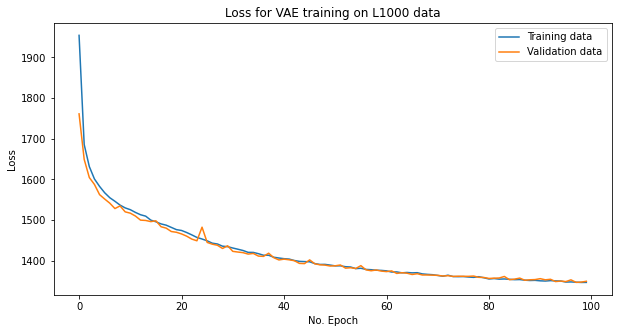

In [17]:
plt.figure(figsize=(10, 5))
plt.plot(history_df["loss"], label="Training data")
plt.plot(history_df["val_loss"], label="Validation data")
plt.title("Loss for VAE training on L1000 data")
# plt.ylabel("Binary cross entropy + KL Divergence")
plt.ylabel("Loss")
plt.xlabel("No. Epoch")
plt.legend()
plt.show()

In [18]:
# evaluating performance using test set
L1000_vae.vae.evaluate(test_features_df)

369/369 [==============================] - 1s 2ms/step - loss: 1344.7906


1344.7906494140625

In [19]:
reconstruction = pd.DataFrame(
    L1000_vae.vae.predict(test_features_df), columns=profile_features
)
(sum(sum((np.array(test_features_df) - np.array(reconstruction)) ** 2))) ** 0.5

3777.132971531209

<AxesSubplot:>

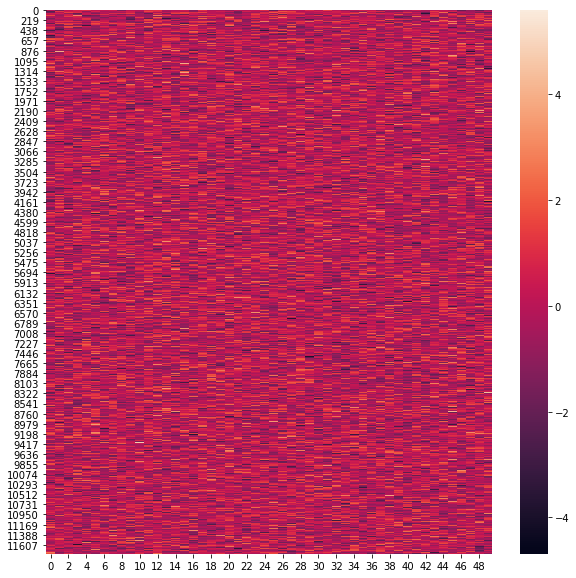

In [20]:
# latent space heatmap
fig, ax = plt.subplots(figsize=(10, 10))
encoder = L1000_vae.encoder_block["encoder"]
latent = np.array(encoder.predict(test_features_df)[2])
seaborn.heatmap(latent, ax=ax)

In [21]:
# original vs reconstructed heatmap
reconstruction = pd.DataFrame(
    L1000_vae.vae.predict(test_features_df), columns=profile_features
)
pca = PCA(n_components=2)
pca_reconstructed_latent_df = pd.DataFrame(pca.fit_transform(reconstruction))
pca_test_latent_df = pd.DataFrame(pca.fit_transform(test_features_df))
# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 10))
# seaborn.heatmap(test_features_df, ax=ax1)
# seaborn.heatmap(reconstruction, ax=ax2)
# plt.show()

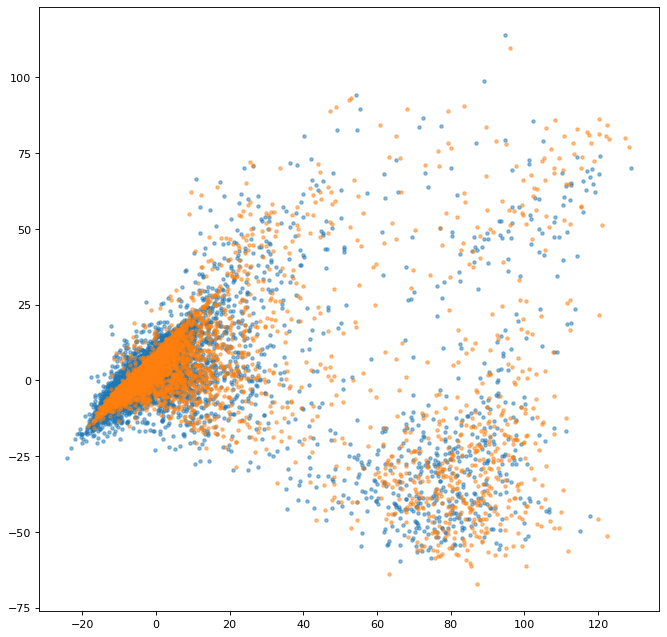

In [22]:
figure(figsize=(10, 10), dpi=80)
plt.scatter(pca_test_latent_df[0],pca_test_latent_df[1], marker = ".", alpha = 0.5)
plt.scatter(pca_reconstructed_latent_df[0],pca_reconstructed_latent_df[1], marker = ".", alpha = 0.5)


In [23]:
decoder = L1000_vae.decoder_block["decoder"]


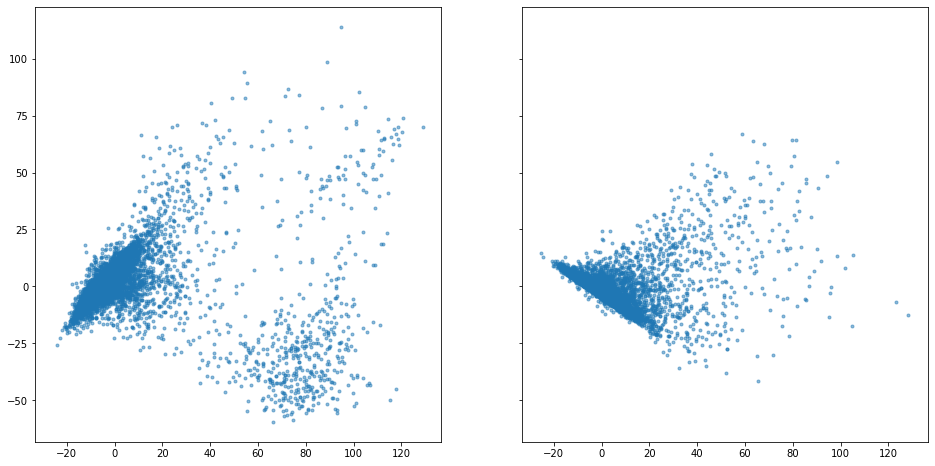

In [24]:
simulated_df = pd.DataFrame(np.random.normal(size=(10000, 50)), columns=np.arange(0,50))
reconstruction_of_simulated = decoder.predict(simulated_df)
pca_reconstruction_of_simulated = pd.DataFrame(pca.fit_transform(reconstruction_of_simulated))
fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(16,8), sharey = True, sharex = True)
ax1.scatter(pca_test_latent_df[0],pca_test_latent_df[1], marker = ".", alpha = 0.5)
ax2.scatter(pca_reconstruction_of_simulated[0],pca_reconstruction_of_simulated[1], marker = ".", alpha = 0.5)


In [25]:
#NOTE: IF YOU RUN THIS, YOU WILL NOT BE ABLE TO REPRODUCE THE EXACT RESULTS IN THE EXPERIMENT
latent_complete = np.array(encoder.predict(complete_features_df)[2])
latent_df = pd.DataFrame(latent_complete)
latent_df.to_csv("../3.application/latentThreeLayer.csv")

In [26]:
#NOTE: IF YOU RUN THIS, YOU WILL NOT BE ABLE TO REPRODUCE THE EXACT RESULTS IN THE EXPERIMENT
decoder.save('./L1000threelayerDecoder')

INFO:tensorflow:Assets written to: ./L1000threelayerDecoder/assets


In [27]:
#NOTE: IF YOU RUN THIS, YOU WILL NOT BE ABLE TO REPRODUCE THE EXACT RESULTS IN THE EXPERIMENT
encoder.save('./L1000threelayerEncoder')

INFO:tensorflow:Assets written to: ./L1000threelayerEncoder/assets
